In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split

In [89]:
x_true_test_df = pd.read_csv("test_processed.csv", index_col=0)
train_df = pd.read_csv("train_processed.csv", index_col=0)

y_train_df = train_df["target"]
x_train_df = train_df.drop("target", axis=1)
# test_df = train_df.drop("accident_id", axis=1)
# train_df = train_df.drop("accident_id", axis=1)

In [90]:
x_train = x_train_df.values
y_train = y_train_df.values
x_true_test = x_true_test_df.values

# Defines

In [81]:
def standarize(df):
    return (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))


def boruta_feature_selection(x, y):
    rfc = RandomForestClassifier(n_estimators=200,
                                 n_jobs=-1,
                                 class_weight='balanced',
                                 max_depth=7,
                                 random_state=0)
    boruta_selector = BorutaPy(rfc,
                               n_estimators='auto',
                               verbose=1,
                               random_state=0)
    boruta_selector.fit(x, y)
    features = np.where(boruta_selector.support_ +
                        boruta_selector.support_weak_ == True)[0]
    print(f"\rBoruta\nNumber of Selected Features: {features.shape[0]}")
    print("Selected Features: ")
    print(*features.tolist())
    return features.tolist()


def calculate_r_2_for_feature(data, feature, regression_type):
    new_data = data.drop(feature, axis=1)

    X_train, \
    X_test,  \
    y_train, \
    y_test = train_test_split(
        new_data,data[feature],test_size=0.25
    )
    if regression_type == "KNR":
        regressor = KNeighborsRegressor()
    elif regression_type == "DTR":
        regressor = DecisionTreeRegressor()
    else:
        raise Exception("Wrong type of regression, use:\n",
                        "KNR for KNeighborsRegressor\n",
                        "DTR for DecisionTreeRegressor")
    regressor.fit(X_train, y_train)

    # score returns the coefficient of determination R^2 of the prediction.
    score = regressor.score(X_test, y_test)
    return score


def calculate_mean_r_2(data, feature, regression_type, iteration=10):
    scores = []
    for i in range(iteration):
        scores.append(calculate_r_2_for_feature(data, feature,
                                                regression_type))
    scores = np.array(scores)
    return scores.mean()


def r_2_score_denoisser(X_train, regression_type="KNR"):
    x_df = pd.DataFrame(X_train)
    avg_r2_feature_scores = []
    for column in tqdm(x_df.columns):
        score = calculate_mean_r_2(x_df.sample(n=30, random_state=1), column,
                                   regression_type)
        avg_r2_feature_scores.append(score)

    features = [i for i, r2 in enumerate(avg_r2_feature_scores) if r2 > 0]
    print("R\u00b2 Score Denoisser\nRegressor:", end=" ")
    if regression_type == "KNR":
        print("KNeighborsRegressor")
    elif regression_type == "DTR":
        print("DecisionTreeRegressor")
    print(f"Number of Selected Features: {len(features)}")
    print("Selected Feaures: ")
    print(*features)
    return features

In [82]:
features_DTR = r_2_score_denoisser(x_train, regression_type="DTR")


R² Score Denoisser
Regressor: DecisionTreeRegressor
Number of Selected Features: 75
Selected Feaures: 
1 7 8 9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 35 36 37 38 40 41 43 44 45 46 47 48 49 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 82 84 85 87 88 89 93 102


In [57]:
features_KNR = r_2_score_denoisser(x_train, regression_type="KNR")


R² Score Denoisser
Regressor: KNeighborsRegressor
Number of Selected Features: 67
Selected Feaures: 
1 8 11 13 14 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 43 44 45 46 47 49 51 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 87 89 98 102


In [58]:
features_boruta = boruta_feature_selection(x_train, y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100


BorutaPy finished running.

Iteration: 	20 / 100
Confirmed: 	16
Tentative: 	0
Rejected: 	87
Boruta
Number of Selected Features: 16
Selected Features: 
0 1 2 3 4 13 14 27 29 37 40 63 75 77 101 102


In [83]:
features = features_boruta

In [91]:
x_train_sel = x_train_df.iloc[:, features]
x_train, x_test, y_train, y_test = train_test_split(x_train_sel,y_df,test_size=0.25)

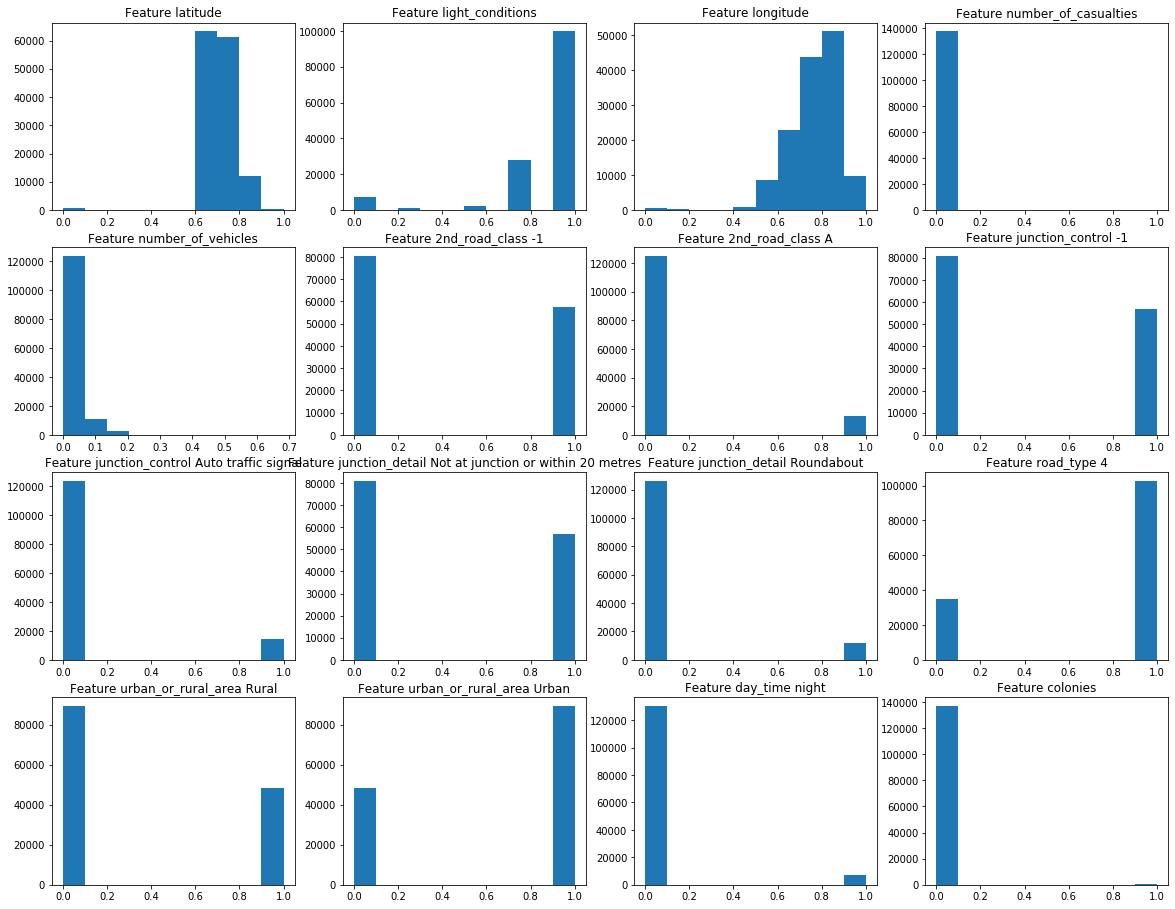

In [92]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(x_train_sel.columns)):
    fig.add_subplot(5, 4, i + 1)
    plt.hist(x_train_sel.iloc[:, i])
    plt.title(f"Feature {x_train_sel.columns[i]}")


# Logistic Regression

In [93]:
logregPipe = Pipeline([('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(random_state=123))])
_ = logregPipe.fit(x_train, y_train)

In [94]:
print('accuracy on the tain set: ', logregPipe.score(x_train, y_train))
print('accuracy on the test set: ', logregPipe.score(x_test, y_test))

accuracy on the tain set:  0.8287677206174479
accuracy on the test set:  0.8277616279069767


           selected parameter
logreg__C            0.031623


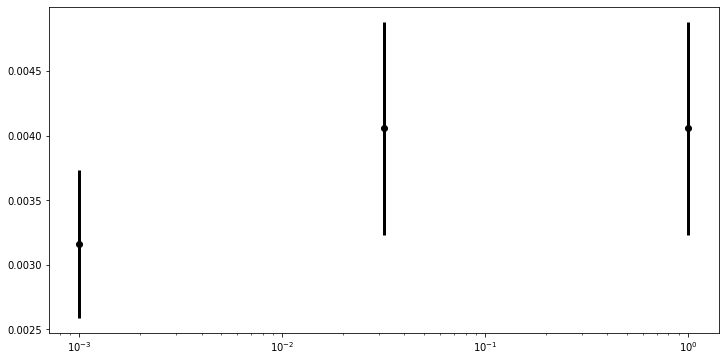

In [100]:
param_space = np.logspace(-3, 0, 3)
logregParam = {'logreg__C': param_space}
logregGS = GridSearchCV(estimator=logregPipe, param_grid=logregParam, cv=5, scoring='f1')
logregGS.fit(x_train, y_train)
print(pd.DataFrame.from_dict(logregGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = logregGS.cv_results_["mean_test_score"]
std_test_score = logregGS.cv_results_["std_test_score"]
plt.figure(figsize=(12, 6))
plt.errorbar(param_space, mean_test_score, std_test_score, fmt='ok', lw=3)
plt.xscale('log')
logregGS.estimator.steps[1][1].C = logregGS.best_params_["logreg__C"]

In [101]:
print("accuracy on the test set: ",
      accuracy_score(y_test, logregGS.predict(x_test)))
print("accuracy on the train set: ",
      accuracy_score(y_train, logregGS.predict(x_train)))

accuracy on the test set:  0.8277325581395348
accuracy on the train set:  0.8287677206174479


In [102]:
logregGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, logregGS.predict(x_test)), columns=['Predicted -1', 'Predicted 1'],\
                                index=['Actual -1', 'Actual 1'])
logregGS_confMatrix

,Predicted -1,Predicted 1
Actual -1,28456,11
Actual 1,5915,18


# KNeighborsClassifier

In [103]:
knnPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1)),
])
knnParam = {
    'knn__n_neighbors': [1, 3, 5, 7, 8, 9, 10, 11],
    'knn__weights': ['uniform', 'distance'],
}
_ = knnPipe.fit(x_train, y_train)

In [104]:
print('accuracy on the train set: ', knnPipe.score(x_train, y_train))
print('accuracy on the test set: ', knnPipe.score(x_test, y_test))

accuracy on the train set:  0.8460256397833312
accuracy on the test set:  0.80375


In [ ]:
knnGS = GridSearchCV(knnPipe, param_grid=knnParam, n_jobs=-1, scoring='f1')
_ = knnGS.fit(x_train, y_train)
print(pd.DataFrame.from_dict(knnGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = knnGS.cv_results_["mean_test_score"]
std_test_score = knnGS.cv_results_["std_test_score"]
plt.figure(figsize=(10, 5))
_ = plt.errorbar(np.arange(mean_test_score.shape[0]),
                 mean_test_score,
                 std_test_score,
                 fmt='ok',
                 lw=3)

In [ ]:
print("accuracy on the train set: ", knnGS.score(x_train, y_train))
print("accuracy on the test set:", knnGS.score(x_test, y_test))

In [ ]:
knnGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, knnGS.predict(x_test)), \
                                columns=['Predicted -1', 'Predicted 1'], \
                                index=['Actual -1', 'Actual 1'])
knnGS_confMatrix

# DecisionTree Classifier

In [ ]:
dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree', DecisionTreeClassifier(random_state=123))])
dectreeParam = {
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': ['balanced', None]
}
_ = dectreePipe.fit(x_train, y_train)

In [ ]:
print('accuracy on the train set: ', dectreePipe.score(x_train, y_train))
print('accuracy on the test set: ', dectreePipe.score(x_test, y_test))

In [ ]:
dectreeGS = GridSearchCV(dectreePipe, param_grid=dectreeParam, cv=5, scoring='f1')
_ = dectreeGS.fit(x_train, y_train)
print(pd.DataFrame.from_dict(dectreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = dectreeGS.cv_results_["mean_test_score"]
std_test_score = dectreeGS.cv_results_["std_test_score"]
plt.figure(figsize=(4, 2))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

In [ ]:
print('accuracy on the train set: ', dectreeGS.score(x_train, y_train))
print('accuracy on the test set: ', dectreeGS.score(x_test, y_test))

In [ ]:
pd.DataFrame(confusion_matrix(y_test, dectreeGS_ypreds),
             columns=['Predicted -1', 'Predicted 1'],
             index=['Actual -1', 'Actual 1'])

# Random Forest

In [ ]:
randtreePipe = Pipeline([('scaler', StandardScaler()),
                         ('randtree',
                          RandomForestClassifier(random_state=123,
                                                 n_estimators=100,
                                                 bootstrap=False))])
max_depth_param = range(5, 25)
randtreeParam = {'randtree__max_depth': max_depth_param}
_ = randtreePipe.fit(x_train, y_train)

In [ ]:
print('accuracy on the train set: ', randtreePipe.score(x_train, y_train))
print('accuracy on the test set: ', randtreePipe.score(x_test, y_test))

In [ ]:
randtreeGS = GridSearchCV(randtreePipe, param_grid=randtreeParam, cv=5, scoring='f1')
randtreeGS.fit(x_train, y_train)
mean_test_score = randtreeGS.cv_results_["mean_test_score"]

std_test_score = randtreeGS.cv_results_["std_test_score"]

print(
    pd.DataFrame.from_dict(randtreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))

pd.DataFrame(randtreeGS.cv_results_).sort_values(by='rank_test_score')[:5][[
    'rank_test_score', 'param_randtree__max_depth', 'mean_test_score',
    'std_test_score'
]].T

plt.figure(figsize=(6, 4))
plt.errorbar(max_depth_param, mean_test_score, std_test_score, fmt='ok')

In [ ]:
print("accuracy on the train set", randtreeGS.score(x_train, y_train))
print("accuracy on the test set", randtreeGS.score(x_test, y_test))

In [ ]:
randtreeGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, randtreeGS_ypreds), columns=['Predicted -1', \
                                                                                               'Predicted 1'],\
                                   index=['Actual -1', 'Actual 1'])
randtreeGS_confMatrix

# Porównanie Dokładności Modeli

In [ ]:
print("Logistic Regression")
print("accuracy on the train set: ", logregGS.score(x_train, y_train))
print("accuracy on the test set: ", logregGS.score(x_test, y_test))

print("\nK-Neighbors Classifier")
print("accuracy on the train set: ", knnGS.score(x_train, y_train))
print("accuracy on the test set:", knnGS.score(x_test, y_test))

print("\nDecision Tree Classifier")
print('accuracy on the train set: ', dectreeGS.score(x_train, y_train))
print('accuracy on the test set: ', dectreeGS.score(x_test, y_test))

print("\nRandomForestClassifier")
print("accuracy on the train set", randtreeGS.score(x_train, y_train))
print("accuracy on the test set", randtreeGS.score(x_test, y_test))

In [ ]:
print("Logistic Regression")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    
    param_space = np.logspace(-3, 0, 100)
    logregParam = {'logreg__C': param_space}
    logregPipe = Pipeline([('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(random_state=123))])
    logregGS = GridSearchCV(estimator=logregPipe, param_grid=logregParam, cv=5, scoring='f1')
    logregGS.fit(x_train, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(logregGS, x_train, y_train, cv=skf,scoring="f1")
    cv_test = cross_val_score(logregGS, x_test, y_test, cv=skf,scoring="f1")
    
    print("\t\tCV f1 on the train set: ", cv_train.mean().round(3)*100, "%")
    print("\t\tCV f1 on the test set:", cv_test.mean().round(3)*100, "%")
    
#     print("\t\taccuracy on the train set: ", logregGS.score(x_train, y_train).round(3))
#     print("\t\taccuracy on the test set:", logregGS.score(x_test, y_test).round(3))

In [ ]:
print("\nK-Neighbors Classifier")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    knnPipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_jobs=-1)),
    ])
    knnParam = {
        'knn__n_neighbors': [1, 3, 5, 7, 8, 9, 10, 11],
        'knn__weights': ['uniform', 'distance'],
    }
    knnGS = GridSearchCV(knnPipe, param_grid=knnParam, n_jobs=-1,scoring="f1")
    _ = knnGS.fit(x_train, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(knnGS, x_train, y_train, cv=skf,scoring="f1")
    cv_test = cross_val_score(knnGS, x_test, y_test, cv=skf,scoring="f1")
    
    print("\t\tCV f1 on the train set: ", (cv_train.mean()*100).round(3), "%")
    print("\t\tCV f1 on the test set:", (cv_test.mean()*100).round(3), "%")
    
#     print("\t\taccuracy on the train set: ", knnGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", knnGS.score(x_test, y_test))

In [ ]:
print("\nDecision Tree Clasifier")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    
    dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree', DecisionTreeClassifier(random_state=123))])
    dectreeParam = {
        'dectree__criterion': ['gini', 'entropy'],
        'dectree__class_weight': ['balanced', None]
    }
    dectreeGS = GridSearchCV(dectreePipe, param_grid=dectreeParam, cv=5,scoring="f1")
    _ = dectreeGS.fit(x_train, y_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(dectreeGS, x_train, y_train, cv=skf,scoring="f1")
    cv_test = cross_val_score(dectreeGS, x_test, y_test, cv=skf,scoring="f1")
    
    print("\t\tCV f1 on the train set: ", (cv_train.mean()*100).round(3), "%")
    print("\t\tCV f1 on the test set:", (cv_test.mean()*100).round(3), "%")
    
#     print("\t\taccuracy on the train set: ", dectreeGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", dectreeGS.score(x_test, y_test))

In [ ]:
print("\nRandom Forest Classifier")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    
    randtreePipe = Pipeline([('scaler', StandardScaler()),
                         ('randtree',
                          RandomForestClassifier(random_state=123,
                                                 n_estimators=100,
                                                 bootstrap=True))])
    max_depth_param = range(5, 25)
    randtreeParam = {'randtree__max_depth': max_depth_param}
    randtreeGS = GridSearchCV(randtreePipe, param_grid=randtreeParam, cv=5,scoring="f1")
    randtreeGS.fit(x_train, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(randtreeGS, x_train, y_train, cv=skf,scoring="f1")
    cv_test = cross_val_score(randtreeGS, x_test, y_test, cv=skf,scoring="f1")
    
    print("\t\tCV f1 on the train set: ", (cv_train.mean()*100).round(3), "%")
    print("\t\tCV f1 on the test set:", (cv_test.mean()*100).round(3), "%")
    
#     print("\t\taccuracy on the train set: ", randtreeGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", randtreeGS.score(x_test, y_test))

In [ ]:
# save_data = knnGS.predict_proba(x_val_sel)[:, 1]
# np.savetxt("foo.csv", save_data, delimiter="", fmt='%f', header="\r\"MATDOR\"")